# Face classifier

## Set up

In [1]:
# Stdlib imports
from pathlib import Path

# 3rd party imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score 
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, f1_score
from sklearn.metrics import r2_score

from IPython.display import display

# Local imports
from facecls import fcaux

2024-07-02 23:42:29.088763: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Configurations

In [2]:
seed = 42

tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
target = "gender"

In [4]:
models_dir = Path(f"results/models/{target.title()}Classifier/")

try:
    last_model_id = max([int(folder.as_posix().split("_")[2]) for folder in models_dir.glob('mlp*')])
except ValueError:
    last_model_id = 0

print("Last model id:", last_model_id)

new_model_id = last_model_id# + 1
file_suffix = f"mlp_{target}_{str(new_model_id).zfill(3)}"
new_model_dir = models_dir / file_suffix
#print(f"Creating folder \"{new_model_dir}\"...")
#new_model_dir.mkdir(parents=True, exist_ok=True)

Last model id: 4


## Load data

In [7]:
data = pd.read_csv("data/age_gender_preproc.csv")

## Challenger model: CNN classifier

In [8]:
full_img_vec_list = np.array([fcaux.pxlstring2pxlvec(data, i) for i in range(data.shape[0])])

### Data split

In [9]:
indeces = list(range(len(full_img_vec_list)))

In [10]:
if "age" in target and not(target == "age_cat"):
    idx_train, idx_test = train_test_split(indeces,
                                           test_size = 0.2,
                                           random_state=seed)
    idx_train, idx_val  = train_test_split(idx_train,
                                           test_size = 0.1,
                                           random_state=seed)

    X_train = full_img_vec_list[idx_train]
    y_train = data[target].values[idx_train]
    X_val = full_img_vec_list[idx_val]
    y_val = data[target].values[idx_val]
    X_test = full_img_vec_list[idx_test]
    y_test = data[target].values[idx_test]
    test_attrs = data[["age", "ethnicity", "gender"]].iloc[idx_test]

else:
    idx_train, idx_test = train_test_split(indeces, 
                                           test_size = 0.2,
                                           stratify = data[target].values,
                                           random_state=seed
                                           )

    idx_train, idx_val  = train_test_split(idx_train, 
                                           test_size = 0.1,
                                           stratify = data[target].values[idx_train],
                                           random_state=seed
                                           )

    X_train = full_img_vec_list[idx_train]
    y_train = data[target].values[idx_train]
    X_val = full_img_vec_list[idx_val]
    y_val = data[target].values[idx_val]
    X_test = full_img_vec_list[idx_test]
    y_test = data[target].values[idx_test]
    test_attrs = data[["age", "ethnicity", "gender"]].iloc[idx_test]

In [11]:
idx_val += (len(idx_train) - len(idx_val))*[np.nan]
idx_test += (len(idx_train) - len(idx_test))*[np.nan]

assert len(idx_train) == len(idx_val)
assert len(idx_train) == len(idx_test)

idx_df = pd.DataFrame({"train_idx": idx_train,
                       "val_idx": idx_val,
                       "test_idx": idx_test}, dtype="Int64")

idx_df.to_csv(new_model_dir / f"data_set_indices__{file_suffix}.csv", index=False)

### Data preprocessing

In [12]:
X_train = X_train.astype("float32")
X_val = X_val.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_val /= 255
X_test /= 255

if target == "age_cat":
    y_train /= age_diff
    y_val /= age_diff
    y_test /= age_diff

In [13]:
if "age" in target and not(target == "age_cat"):
    num_classes = 0
else:
    num_classes = data[target].nunique()
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)

print("num_classes =", num_classes)

num_classes = 2


### Building the CNN model (AlexNet architecture)

In [14]:
input_img = Input(shape=X_train[0].shape)
dense1 = Dense(1024, activation="relu")(input_img)
dense1 = Dense(1024, activation="relu")(dense1)
dense1 = Dense(1024, activation="relu")(dense1)
dense1 = Dense(1024, activation="relu")(dense1)
dense1 = Dense(1024, activation="relu")(dense1)
dense1 = Dense(1024, activation="relu")(dense1)
if num_classes == 2:
    out = Dense(num_classes, activation="sigmoid")(dense1)
elif num_classes > 2:
    out = Dense(num_classes, activation="softmax")(dense1)
else:
    out = Dense(1, activation="linear")(dense1)

mlp = Model(input_img, out)

In [15]:
mlp.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,610,370 (29.03 MB)

 Trainable params: 7,610,370 (29.03 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
adam = keras.optimizers.Adam()

if num_classes == 2:
    loss = "binary_crossentropy"
    metrics_list = ["accuracy"]
    
elif num_classes > 2:
    loss = "categorical_crossentropy"
    metrics_list = ["accuracy"]
    
else:
    loss = "mean_squared_error"
    #loss = "mean_absolute_percentage_error"
    metrics_list = ["r2_score", "mean_squared_error", "mean_absolute_percentage_error"]
    
mlp.compile(optimizer=adam,
            loss=loss,
            metrics=metrics_list)

In [17]:
n_epochs = 27
mlp_history = mlp.fit(X_train, y_train,
                      epochs=n_epochs,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      shuffle=True
                     )             

Epoch 1/27
534/534 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - accuracy: 0.6192 - loss: 0.6517 - val_accuracy: 0.7665 - val_loss: 0.5122
Epoch 2/27
534/534 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.7840 - loss: 0.4674 - val_accuracy: 0.5973 - val_loss: 0.5844
Epoch 3/27
534/534 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.8048 - loss: 0.4184 - val_accuracy: 0.6874 - val_loss: 0.5085
Epoch 4/27
534/534 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.8141 - loss: 0.3990 - val_accuracy: 0.7575 - val_loss: 0.4299
Epoch 5/27
534/534 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.8213 - loss: 0.3772 - val_accuracy: 0.7348 - val_loss: 0.4767
Epoch 6/27
534/534 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.8093 - loss: 0.4008 - val_accuracy: 0.7733 - val_loss: 0.4421
Epoch 7/27
534/534 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.8229 - loss: 0.3717 - val_accuracy: 0.8355 - val_loss: 0.3402
Epoch 8/27
534/534 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.8293 - loss: 0.3552 - 

In [18]:
mlp.save(new_model_dir / f'{file_suffix}_refit_nepochs27.keras')

In [19]:
history = mlp_history.history
n_epochs = len(history[list(history.keys())[0]])
history["epoch"] = list(range(1, n_epochs+1))

# in general I don't know the names of the other columns. Therefore:
other_columns = [k for k, v in history.items() if k!="epoch"] 

history_df = pd.DataFrame(history, columns = ["epoch"] + other_columns)
file_name = f'history__{file_suffix}_refit_nepochs27.csv'
history_df.to_csv(new_model_dir / file_name, index=False)

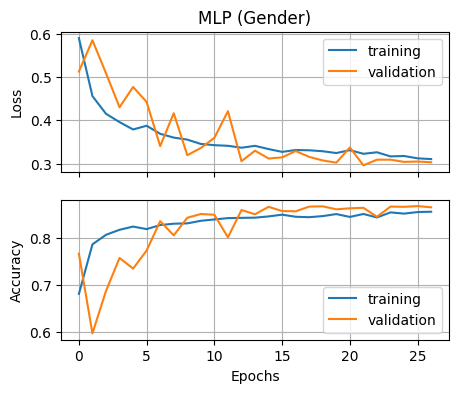

In [20]:
fig, axs = plt.subplots(2,1, figsize=(5,4), sharex=True)
ax = axs[0]
ax.plot(mlp_history.history["loss"], label="training")
ax.plot(mlp_history.history["val_loss"], label="validation")
ax.grid(True)
ax.set_xticks(range(0,n_epochs,5))
ax.set_ylabel("Loss")
ax.set_title(f"MLP ({target.title()})")
ax.legend(loc="best")

ax = axs[1]
ax.plot(mlp_history.history["accuracy"], label="training")
ax.plot(mlp_history.history[f"val_accuracy"], label="validation")
ax.grid(True)
ax.set_xticks(range(0,n_epochs,5))
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")#metric.title())
ax.legend(loc="best")

plt.savefig(new_model_dir / f"loss_curve__{file_suffix}_refit_nepochs27.png",
            bbox_inches='tight')
plt.show()

In [21]:
y_prob_train = mlp.predict(X_train)
y_pred_train = np.array([np.argmax(i) for i in y_prob_train])

y_prob_val = mlp.predict(X_val)
y_pred_val = np.array([np.argmax(i) for i in y_prob_val])

y_prob_test = mlp.predict(X_test)
y_pred_test = np.array([np.argmax(i) for i in y_prob_test])

534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [22]:
train_metrics = {"accuracy": accuracy_score(np.array([np.argmax(i) for i in y_train]), y_pred_train),
                "balanced_accuracy": balanced_accuracy_score(np.array([np.argmax(i) for i in y_train]), y_pred_train),
                "roc_auc": roc_auc_score(np.array([np.argmax(i) for i in y_train]), y_prob_train[:,1]),
                "F1": f1_score(np.array([np.argmax(i) for i in y_train]), y_pred_train)}

val_metrics = {"accuracy": accuracy_score(np.array([np.argmax(i) for i in y_val]), y_pred_val),
                "balanced_accuracy": balanced_accuracy_score(np.array([np.argmax(i) for i in y_val]), y_pred_val),
                "roc_auc": roc_auc_score(np.array([np.argmax(i) for i in y_val]), y_prob_val[:,1]),
                "F1": f1_score(np.array([np.argmax(i) for i in y_val]), y_pred_val)}

test_metrics = {"accuracy": accuracy_score(y_test, y_pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_test),
                "roc_auc": roc_auc_score(y_test, y_prob_test[:,1]),
                "F1": f1_score(y_test, y_pred_test)}

metrics_df = pd.DataFrame({"train": train_metrics, 
                           "val": val_metrics, 
                           "test": test_metrics})

display(metrics_df)
metrics_df.to_csv(new_model_dir / f"metrics__{file_suffix}.csv")

,train,val,test
accuracy,0.864592,0.865050,0.847711
balanced_accuracy,0.862342,0.863603,0.845385
roc_auc,0.948736,0.947539,0.934979
F1,0.851411,0.854711,0.832715


In [23]:
fpr, tpr, thr = roc_curve(y_test, y_prob_test[:,1])
pd.DataFrame({"FPR": fpr, "TPR": tpr}).to_csv(new_model_dir / f"fpr_vs_tpr__{file_suffix}.csv")

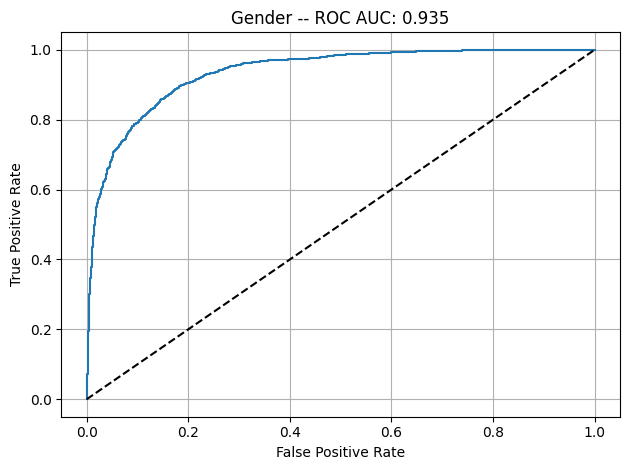

In [24]:
fig, ax = plt.subplots()
ax.plot(fpr,tpr)
ax.plot([0,1], [0,1], ls="--", c="k")
ax.grid(True)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title(f"{target.title()} -- ROC AUC: {np.round(roc_auc_score(y_test, y_prob_test[:,1]),4)}")
plt.tight_layout()
plt.savefig(new_model_dir / f"roc_curve__{file_suffix}.png",
            bbox_inches='tight')
plt.show()

In [25]:
cls_report = pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True))
cls_report.to_csv(new_model_dir / f"classificationo_report__{file_suffix}.png")

### Analysis

In [26]:
test_data = data.iloc[[i for i in idx_test if i==i]].reset_index(drop=True)

In [27]:
ethnicity_groups = dict()

for ethn_idx in test_data["ethnicity"].unique():
    ethnicity_groups[ethn_idx] = list(test_data[test_data["ethnicity"]==ethn_idx].index)

In [28]:
performance_by_ethnicity = dict()
for ethn in range(5):
    y_prob_ethn = mlp.predict(X_test[ethnicity_groups[ethn]])
    y_pred_ethn = np.array([np.argmax(i) for i in y_prob_ethn])
    acc = accuracy_score(y_test[ethnicity_groups[ethn]], y_pred_ethn)
    rocauc = roc_auc_score(y_test[ethnicity_groups[ethn]], y_pred_ethn)

    performance_by_ethnicity[ethn] = {"accuracy": acc, 
                                      "ROC_AUC": rocauc}

# Convert to data frame for easier plotting
performance_by_ethnicity_df = pd.DataFrame(performance_by_ethnicity).transpose()

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [29]:
age_groups = dict()

for age_idx in test_data["age_decades"].unique():
    age_groups[age_idx] = list(test_data[test_data["age_decades"]==age_idx].index)

In [30]:
performance_by_age = dict()
for age_idx in test_data["age_decades"].unique():
    y_prob_age = mlp.predict(X_test[age_groups[age_idx]])
    y_pred_age = np.array([np.argmax(i) for i in y_prob_age])
    acc = accuracy_score(y_test[age_groups[age_idx]], y_pred_age)
    try:
        rocauc = roc_auc_score(y_test[age_groups[age_idx]], y_pred_age)
    except ValueError:
        rocauc = np.nan

    performance_by_age[age_idx] = {"accuracy": acc, 
                                      "ROC_AUC": rocauc}

sorted_columns = sorted([k for k,v in performance_by_age.items()])
performance_by_age_df = pd.DataFrame(performance_by_age, 
                                     columns = sorted_columns).transpose()

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


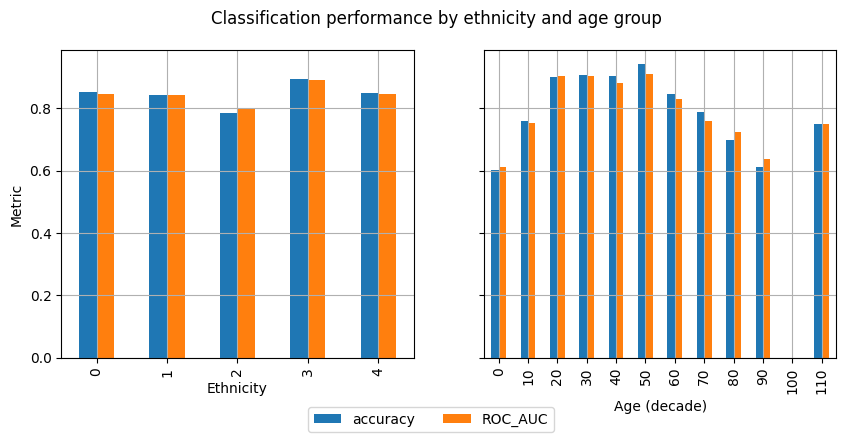

In [31]:
fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True, gridspec_kw = {"hspace": 0.07})
ax = axs[0]
performance_by_ethnicity_df.plot(kind="bar", ax = ax, grid=True, legend=False)
ax.set_xlabel("Ethnicity")
ax.set_ylabel("Metric")

ax = axs[1]
performance_by_age_df.plot(kind="bar", ax = ax, grid=True)
ax.set_xlabel("Age (decade)")
ax.legend(loc="center", bbox_to_anchor=(-0.15,-0.2), ncol=2)

fig.suptitle("Classification performance by ethnicity and age group")

plt.savefig(new_model_dir / f"cls_performance_analysis__{file_suffix}", 
            bbox_inches='tight')
plt.show()